<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="uptrain">
  </a>
</h1>

<h1 style="text-align: center;">Monitoring a Trip Time prediction model</h1>

**Overview**: In this example, we consider a regression task where we want to predict the trip time given the trip pickup & dropoff co-ordinates, number of passengers, booking date etc. 

**Dataset**: Input dataset contains features such as vendor_id, pickup_datetime, passenger_count, pickup_location, drop_location etc. The output is trip duration (in seconds). The dataset is available to download from [Kaggle](https://www.kaggle.com/competitions/nyc-taxi-trip-duration/data).

**Monitoring**: In this notebook, we will see how we can use UpTrain package to monitor model performance, run data integrity checks, and identify data drift.

#### Install required packages for this example [LightGBM]
Note: For mac users, try conda installation if pip doesn't work

In [1]:
#! pip install lightgbm

In [2]:
import pandas as pd
from sklearn import model_selection, metrics
from lightgbm import LGBMRegressor
import time
import uptrain
import os
from helper_funcs import download_datasets, process

First, download the dataset from [Kaggle](https://www.kaggle.com/competitions/nyc-taxi-trip-duration/data) into current directory.

In [3]:
base_dir = download_datasets()

In [4]:
df_train = pd.read_csv(os.path.join(base_dir, "train.csv"))

y = df_train["trip_duration"]
X = df_train.drop(["trip_duration"], axis = 1)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.1)
test_ids = list(X_test['id'])

# Cleanup data to, for instance, find distance from latitude and longitude
X_train = process(X_train)
X_test = process(X_test)

In [5]:
X_train.head(3)

,vendor_id,passenger_count,store_and_fwd_flag,dist,pickup_year,pickup_month,pickup_day,pickup_dow,pickup_hour,pickup_min,pickup_sec
223984,2,5,0,0.073789,2016,3,26,5,3,54,30
214793,1,1,0,0.005480,2016,5,3,1,11,9,31
506797,1,1,0,0.022400,2016,6,22,2,7,39,43


In [6]:
m = LGBMRegressor(n_estimators=500) 
m.fit(X_train, y_train)

LGBMRegressor(n_estimators=500)

In [7]:
preds = abs(m.predict(X_train))
err_train = metrics.mean_absolute_percentage_error(y_train, preds)
print(f"Training Mean Absolute Error: {err_train * 100} %")

Training Mean Absolute Error: 73.0892917751416 %


In [8]:
cfg = {
    "checks": [
        {
            "type": uptrain.Monitor.DATA_INTEGRITY,
            "measurable_args": {
                'type': uptrain.MeasurableType.INPUT_FEATURE,
                'feature_name': 'passenger_count'
            },
            "integrity_type": "greater_than",
            "threshold": 1
        },
        {
            # To monitor Mean Absolute Error (MAE)
            "type": uptrain.Monitor.ACCURACY,
            "measurable_args": {
                'type': uptrain.MeasurableType.MAE,
            },
        },
        {
            # To monitor Mean Absolute Percentage Error (MAPE)
            "type": uptrain.Monitor.ACCURACY,
            "measurable_args": {
                'type': uptrain.MeasurableType.MAPE,
            },
        },
        {
            # To visualize the SHAP explanability in dashboard
            "type": uptrain.Visual.SHAP,
            "model": m,
            "shap_num_points": 10000,
            "id_col": "id"
        },
    ],
    "logging_args": {"st_logging": True},
}
framework = uptrain.Framework(cfg_dict=cfg)

batch_size = 5000
cols = list(X_test.columns)
for idx in range(int(len(X_test)/batch_size)):
    
    indices = range(idx*batch_size, (idx+1)*batch_size)
    this_elems = X_test.iloc[idx*batch_size: (idx+1)*batch_size, :]
    this_preds = abs(m.predict(this_elems))
    
    # Add ids to corresponding data points to preserve them in dashboard
    this_elems = this_elems.assign(id=list(test_ids[idx*batch_size: (idx+1)*batch_size]))
    
    # Log input and outputs to the UpTrain framework
    ids = framework.log(inputs=this_elems, outputs=this_preds)
    
    # Attach ground truth
    ground_truth = list(y_test[idx*batch_size: (idx+1)*batch_size])
    framework.log(identifiers=ids, gts=ground_truth)
    
    time.sleep(0.01)

Deleting the folder:  uptrain_smart_data
Deleting the folder:  uptrain_logs

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8504
  Network URL: http://192.168.6.64:8504

  For better performance, install the Watchdog module:

  $ xcode-select --install
  $ pip install watchdog
            


In [9]:
import shap
explainer = shap.Explainer(m)
shap_values = explainer(X_test[0:10000])

In [10]:
shap_values.values.shape

(10000, 11)

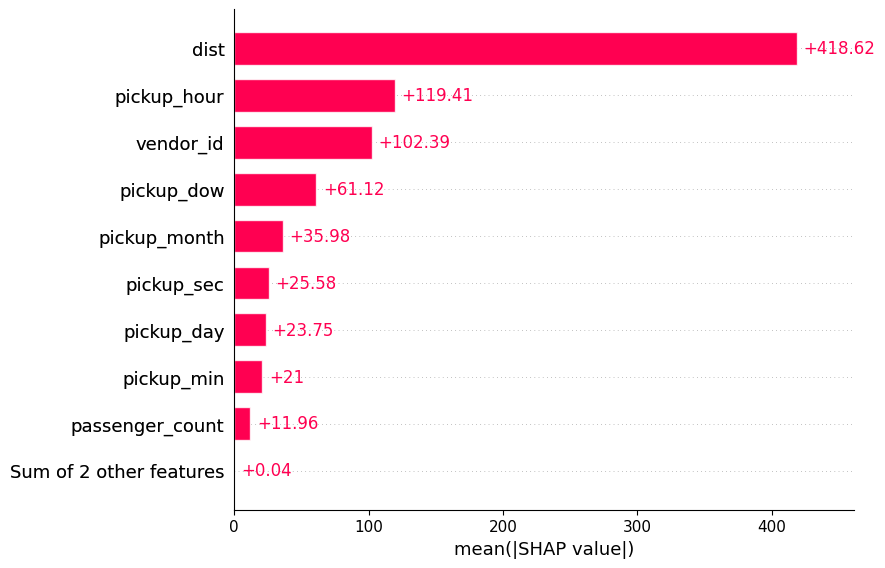

In [11]:
shap.plots.bar(shap_values)

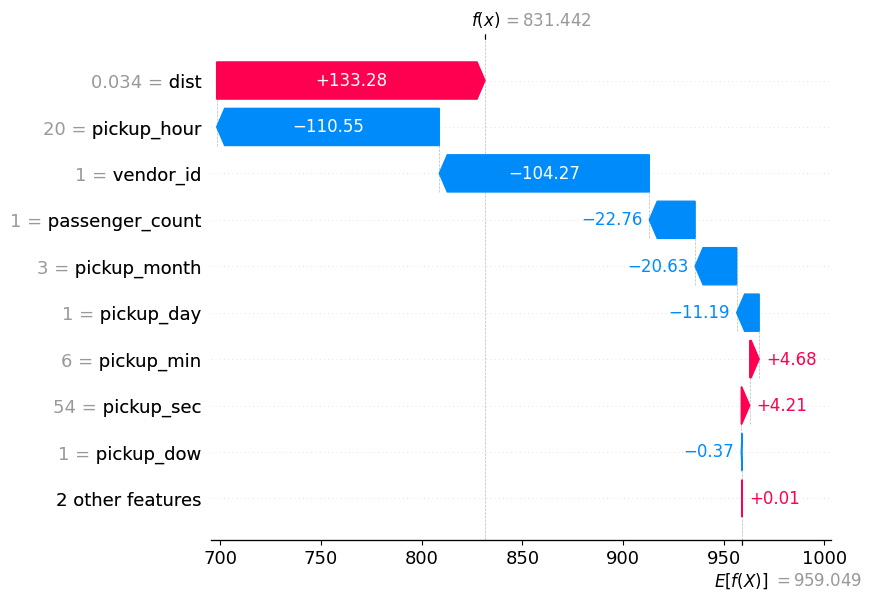

In [12]:
shap.plots.waterfall(shap_values[0])

In [17]:
shap.initjs()
shap.plots.force(shap_values[0:100])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


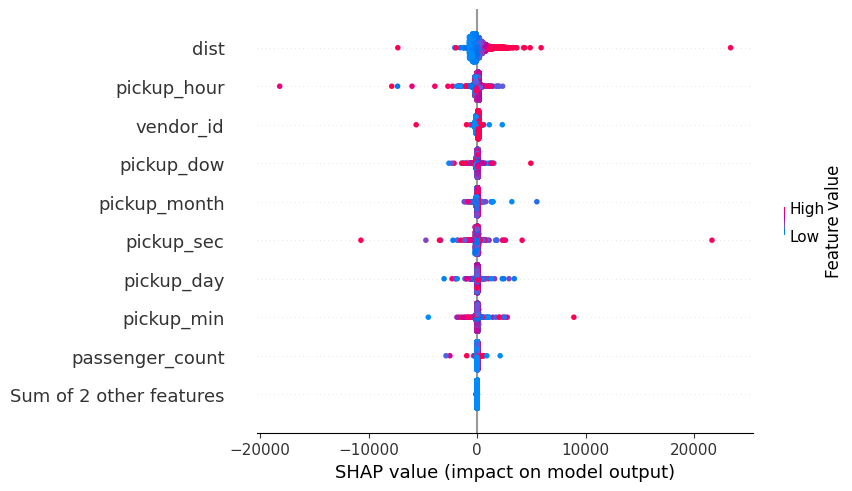

In [14]:
shap.plots.beeswarm(shap_values)

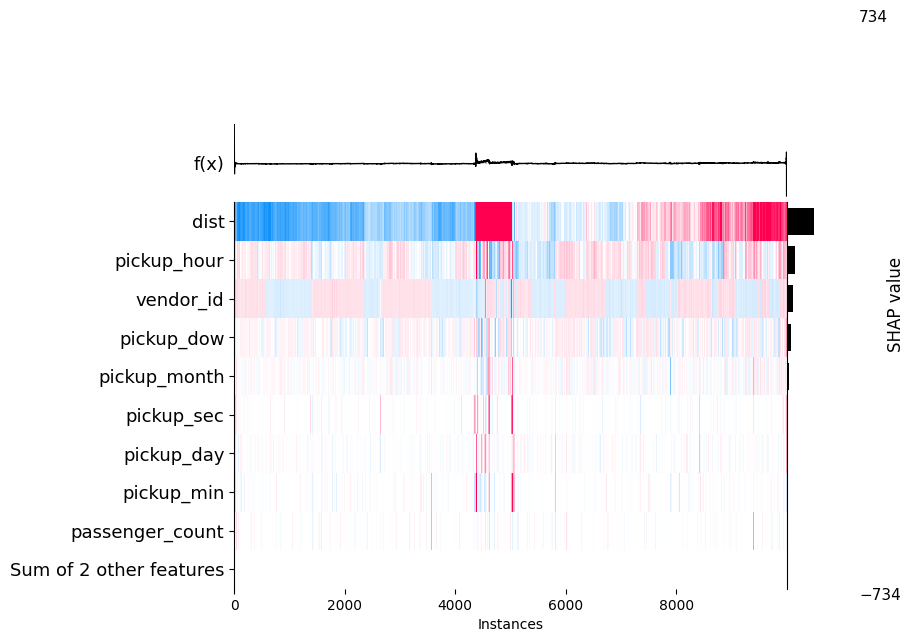

In [15]:
shap.plots.heatmap(shap_values)

In [37]:
list(X_test.iloc[10])

[2.0, 4.0, 0.0, 0.01069644990553296, 2016.0, 3.0, 1.0, 1.0, 14.0, 51.0, 5.0]

In [33]:
pd.DataFrame(X_test.iloc[10]).transpose()

,vendor_id,passenger_count,store_and_fwd_flag,dist,pickup_year,pickup_month,pickup_day,pickup_dow,pickup_hour,pickup_min,pickup_sec
1318030,2.0,4.0,0.0,0.010696,2016.0,3.0,1.0,1.0,14.0,51.0,5.0


In [24]:
X_test.iloc[10:12]

,vendor_id,passenger_count,store_and_fwd_flag,dist,pickup_year,pickup_month,pickup_day,pickup_dow,pickup_hour,pickup_min,pickup_sec
1318030,2,4,0,0.010696,2016,3,1,1,14,51,5
515613,1,1,0,0.049238,2016,3,25,4,22,11,26


In [45]:
sum(shap_values.values[0])

-127.60633367901087

In [43]:
np.dot(shap_values[0].values, shap_values[0].data)

-2151.771898262224

In [47]:
preds[0]

1537.9816874476655

In [53]:
sum(shap_values[0].values)

-127.60633367901087

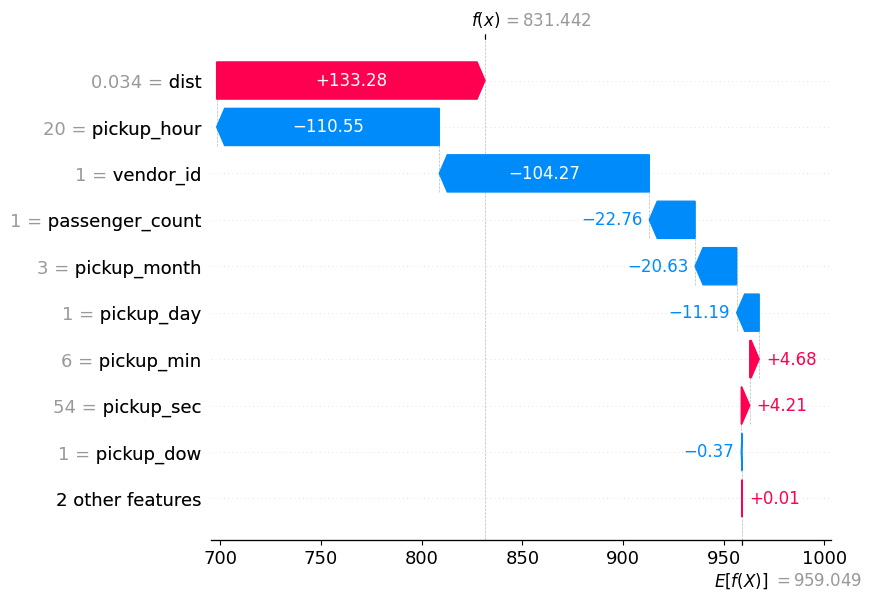

In [50]:
shap.plots.waterfall(shap_values[0])